Head of the dataset:
               TICKER DTYYYYMMDD   FIRST    HIGH     LOW   CLOSE  \
0  S*Mobarakeh.Steel 2025-01-21  5530.0  5650.0  5430.0  5530.0   
1  S*Mobarakeh.Steel 2025-01-20  5630.0  5650.0  5500.0  5520.0   
2  S*Mobarakeh.Steel 2025-01-19  5670.0  5770.0  5610.0  5670.0   
3  S*Mobarakeh.Steel 2025-01-18  5800.0  5830.0  5660.0  5690.0   
4  S*Mobarakeh.Steel 2025-01-15  5900.0  5980.0  5750.0  5830.0   

           VALUE        VOL  OPENINT PER    OPEN    LAST  
0  1049246500100  189657707     7862   D  5520.0  5610.0  
1  2205206368180  399145970    10367   D  5670.0  5500.0  
2   778586674340  137314779     6550   D  5690.0  5690.0  
3  1421637670700  250028468     9125   D  5830.0  5670.0  
4  1034211539250  177394846     8218   D  5860.0  5790.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TICKER      3

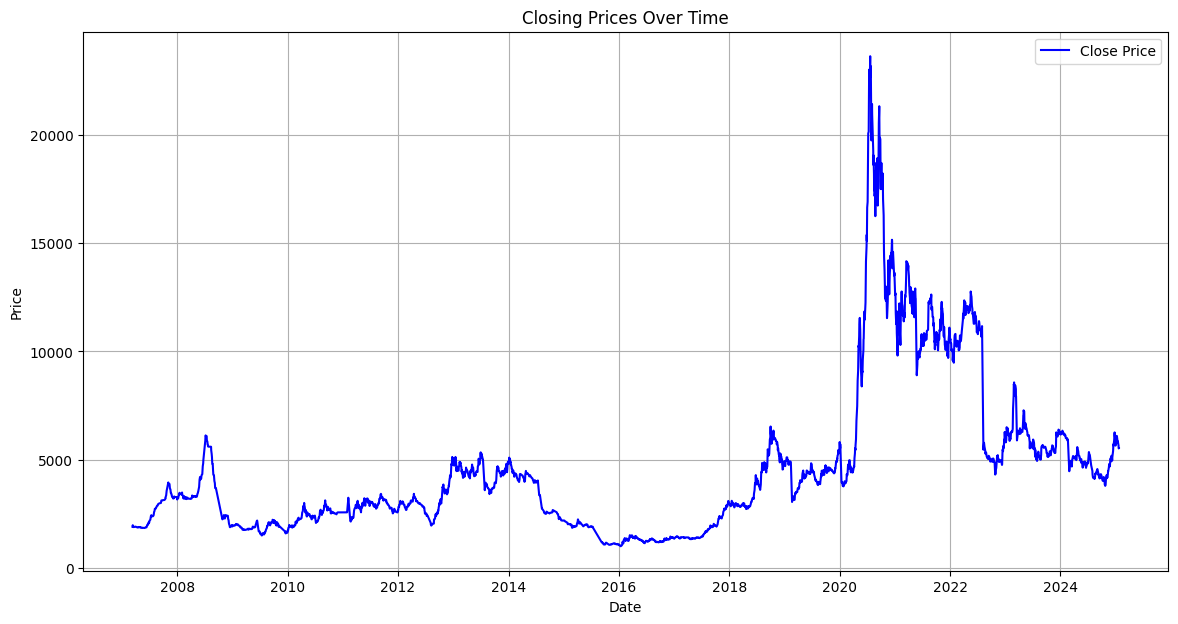

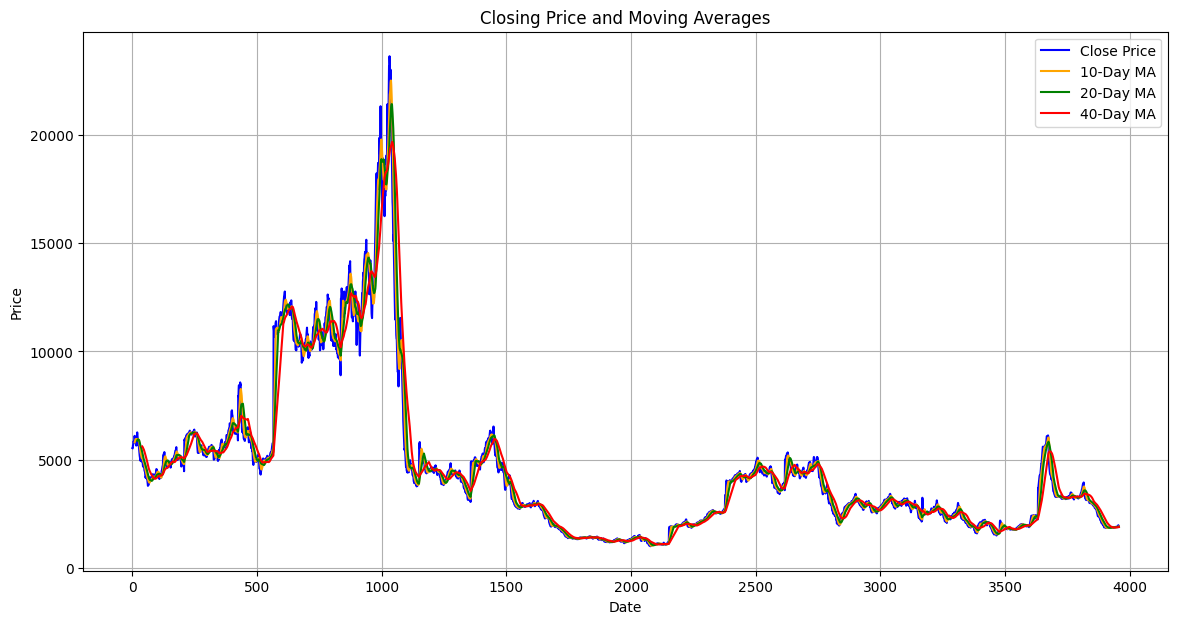

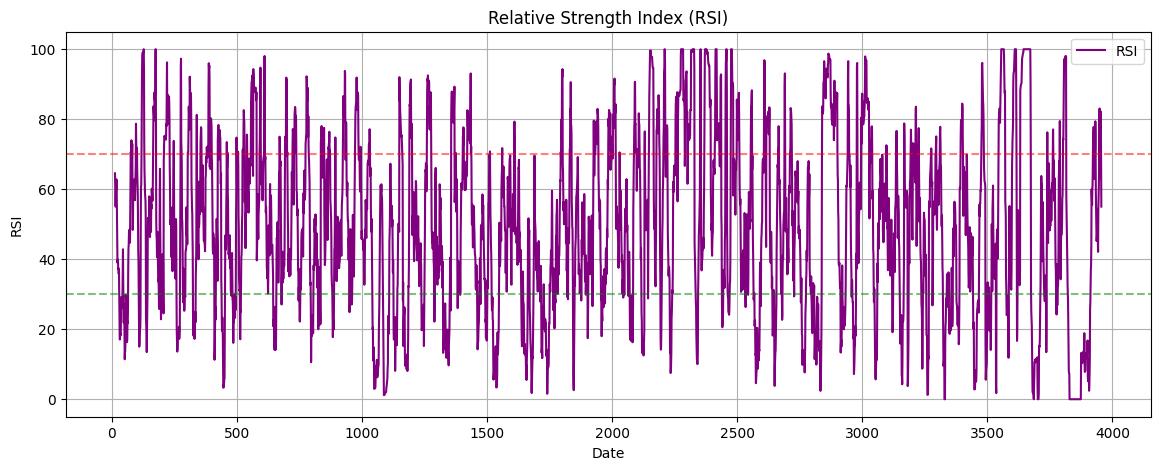

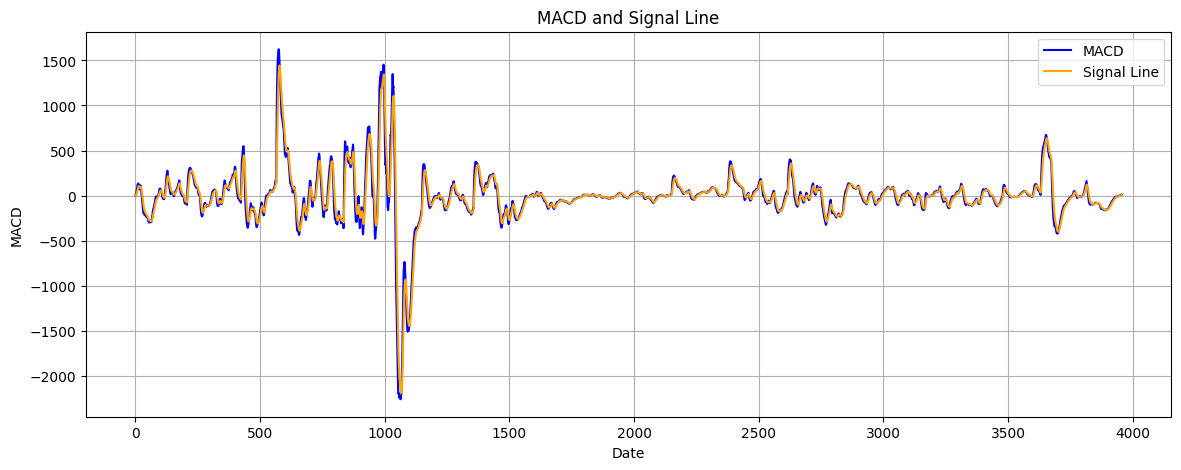

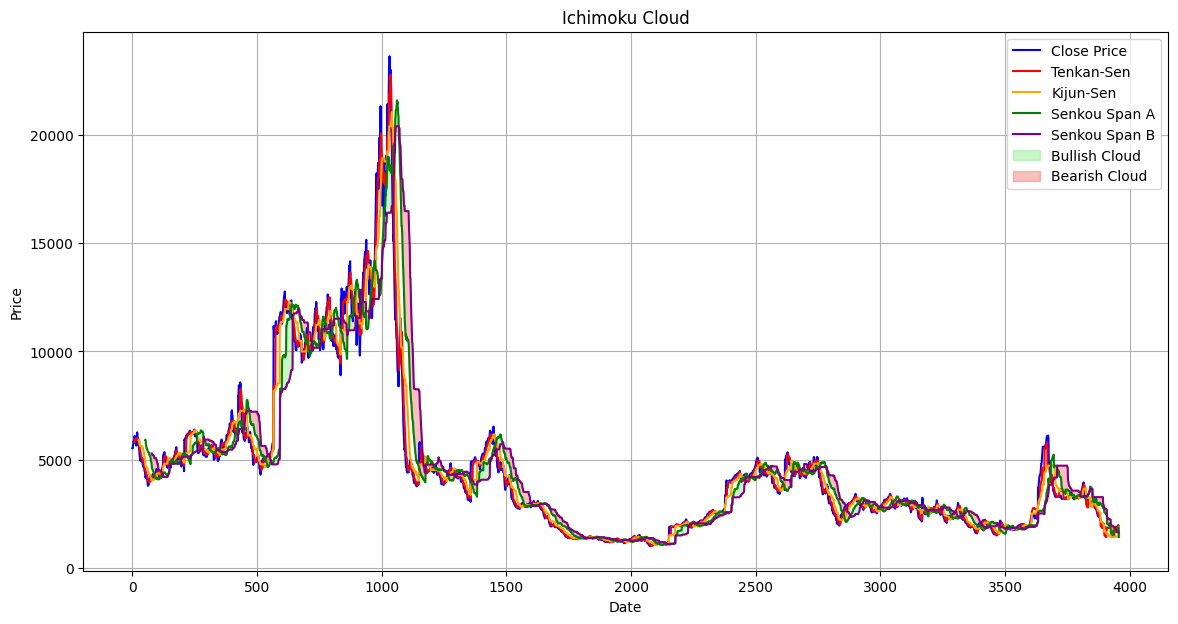

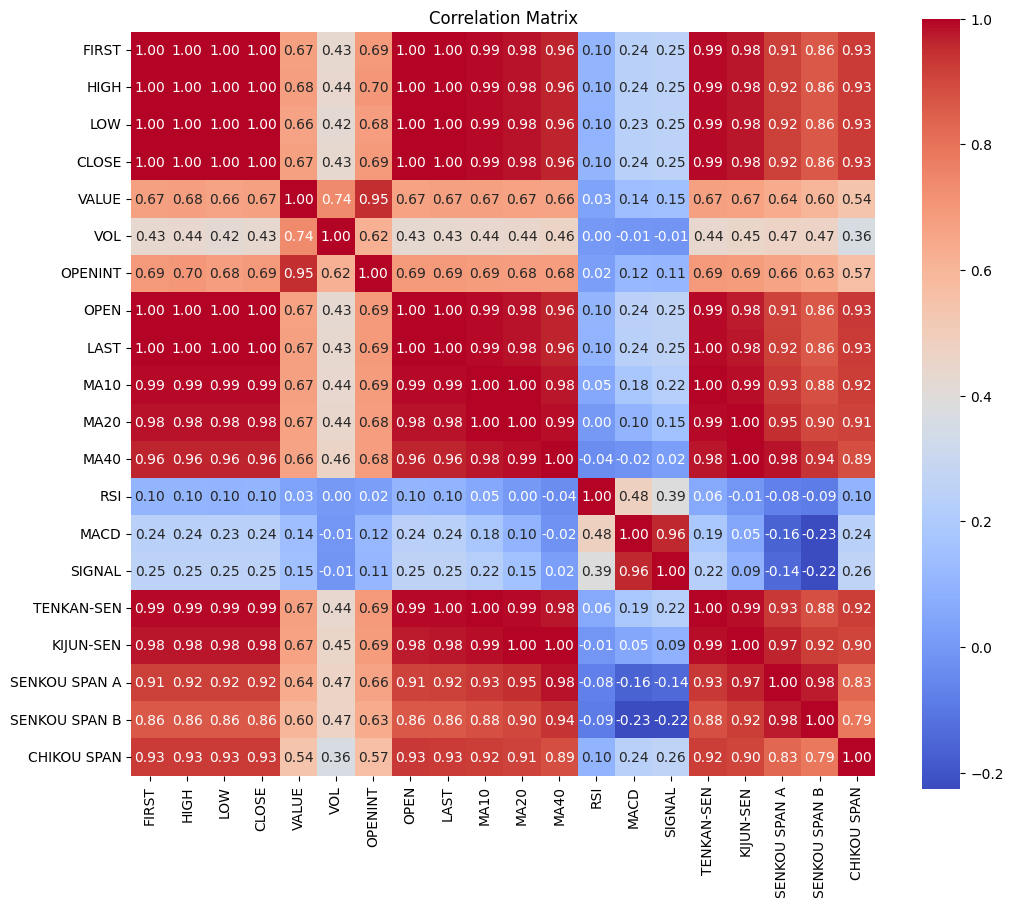

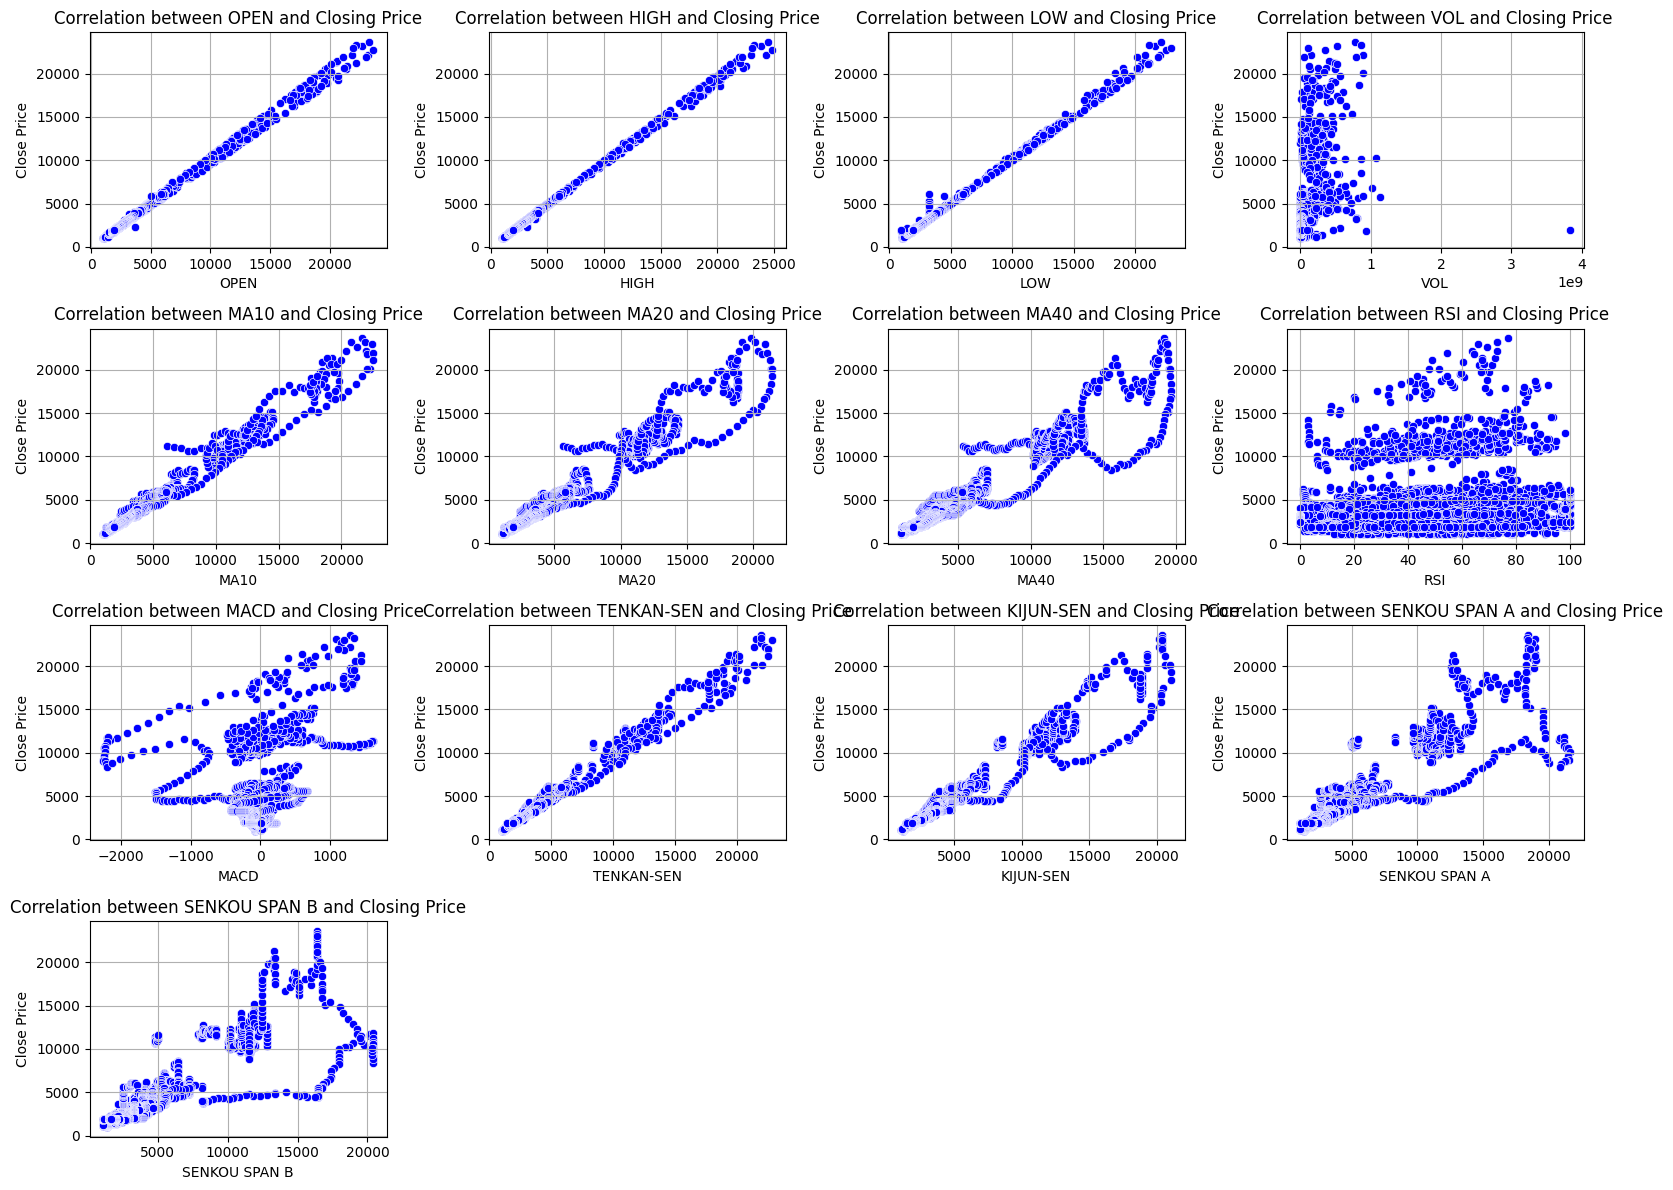

Selected features based on correlation with Closing Price:
['FIRST', 'HIGH', 'LOW', 'VALUE', 'OPENINT', 'OPEN', 'LAST', 'MA10', 'MA20', 'MA40', 'TENKAN-SEN', 'KIJUN-SEN', 'SENKOU SPAN A', 'SENKOU SPAN B', 'CHIKOU SPAN']
               Model           MSE         MAE        R²        CV MSE  \
0  Linear Regression  2.703836e+03   26.116978  0.999784  2.229756e+03   
1      Decision Tree  9.167913e+03   39.281566  0.999267  7.721062e+03   
2                SVM  4.790444e+06  738.308837  0.616966  5.230632e+06   
3      Random Forest  3.973090e+03   24.899738  0.999682  4.429459e+03   

                                 Best Params  
0                                         {}  
1                        {'max_depth': None}  
2                 {'C': 10, 'gamma': 'auto'}  
3  {'max_depth': 15, 'min_samples_split': 2}  


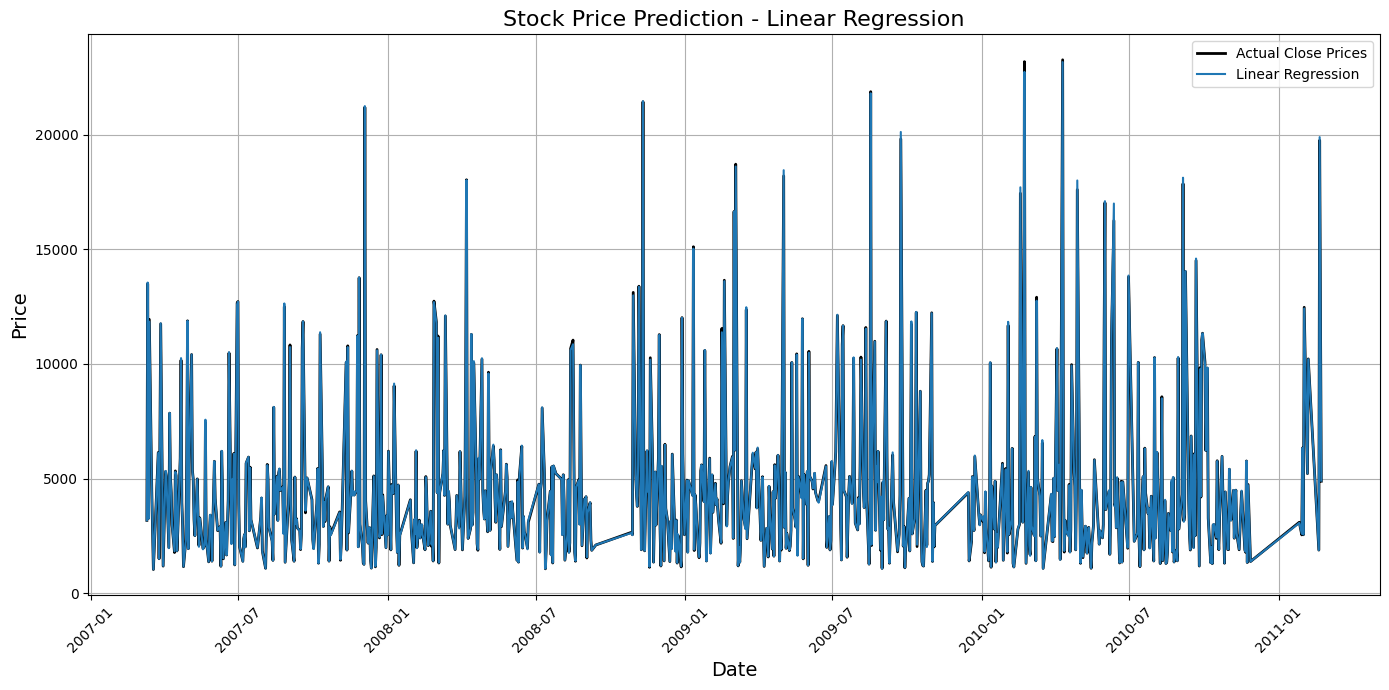

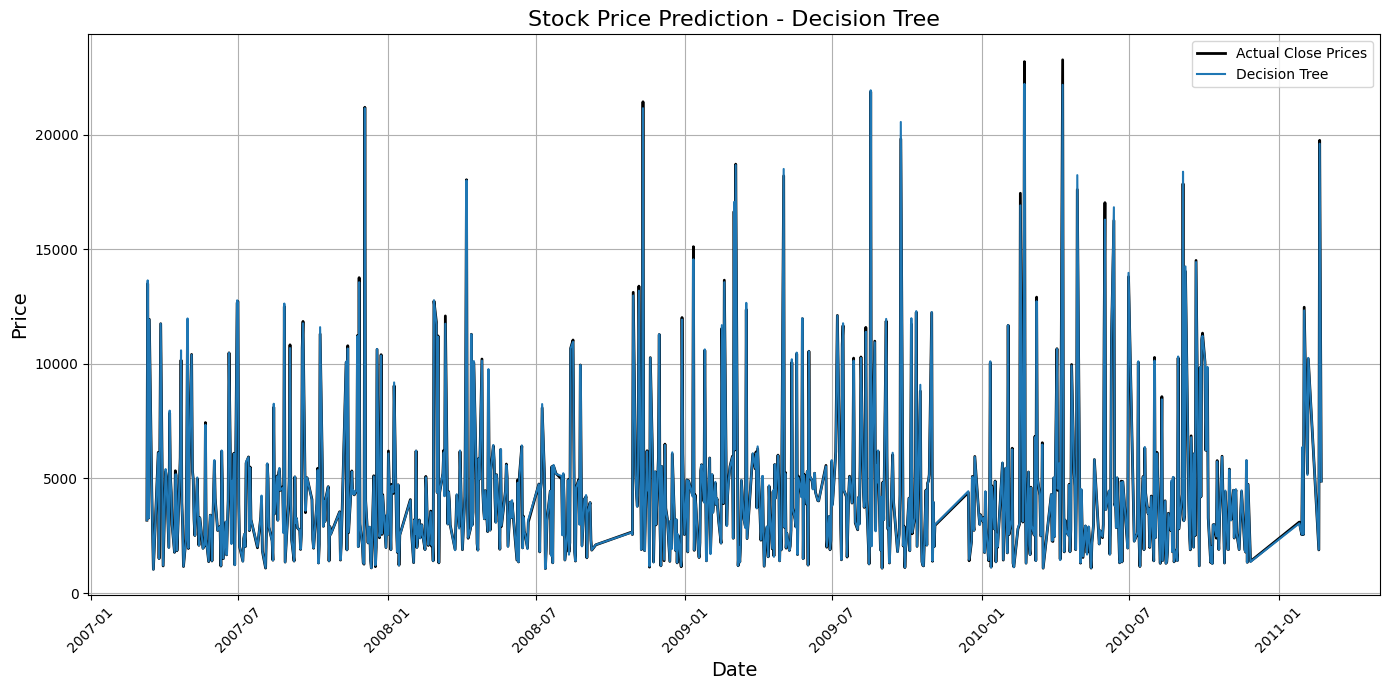

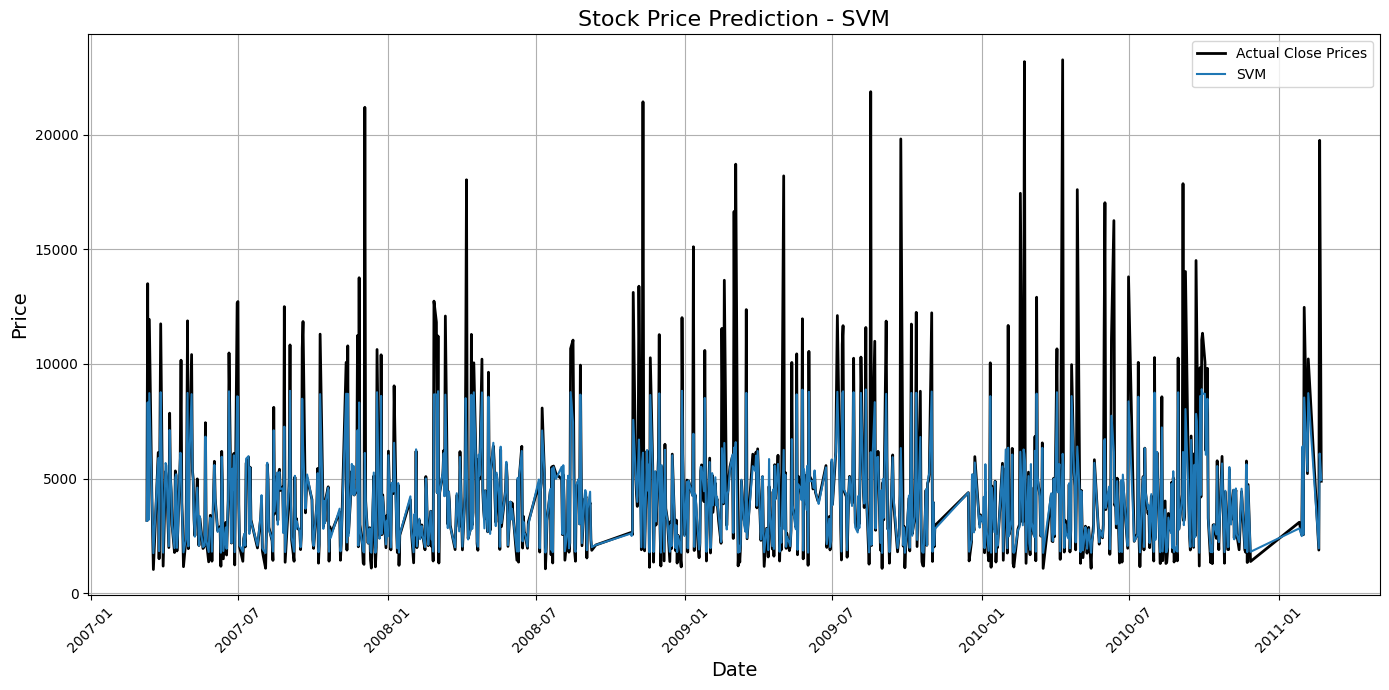

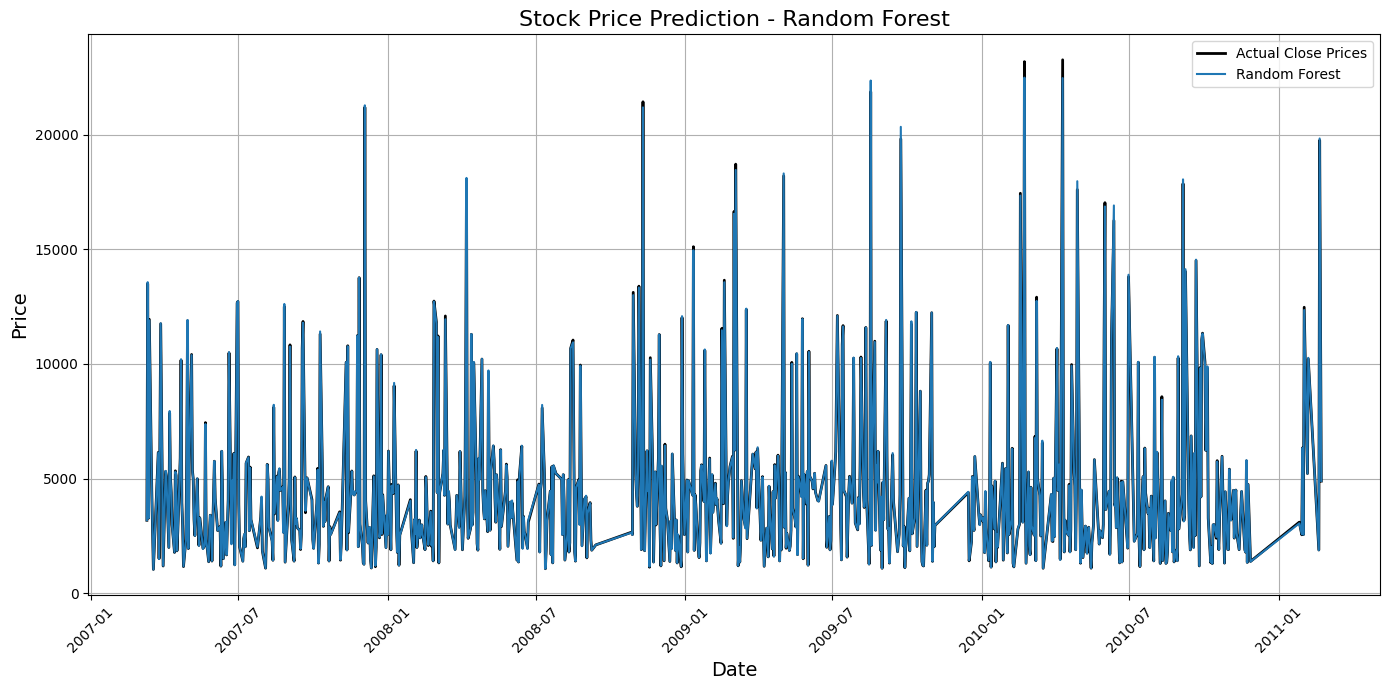

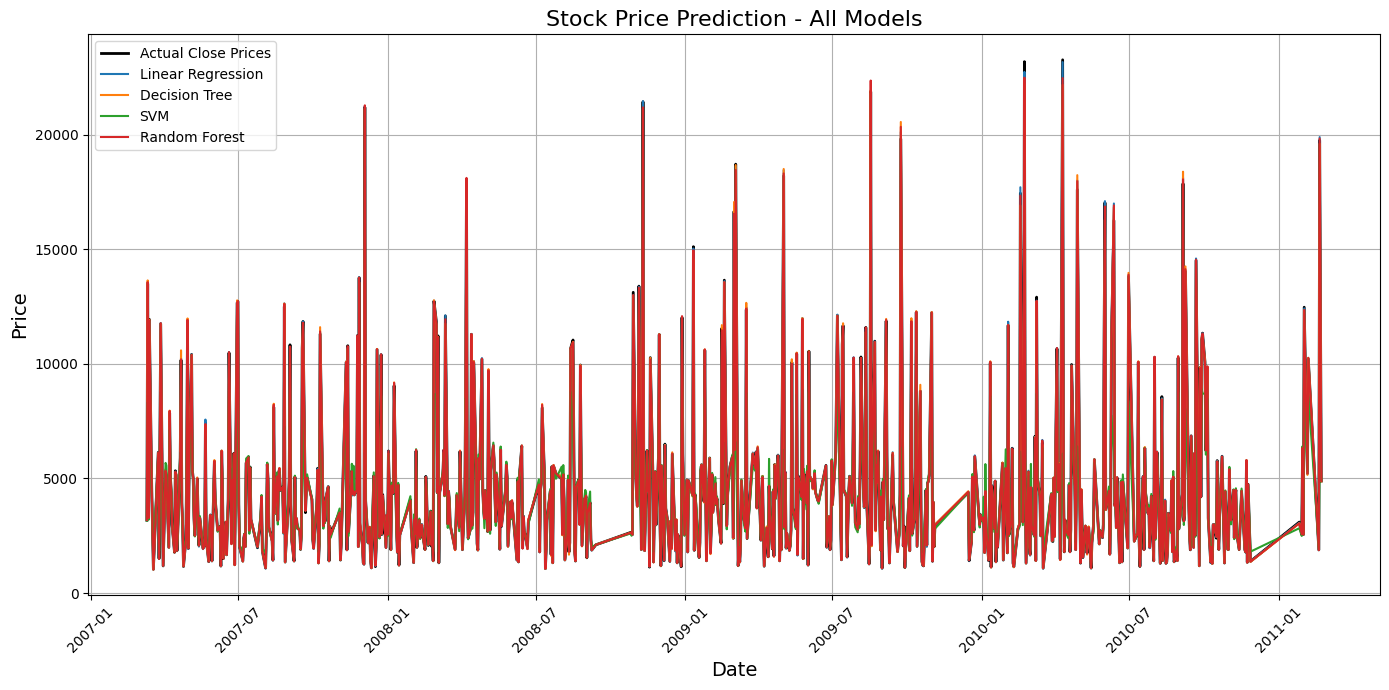

In [11]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Loading data from CSV file
data = pd.read_csv('S_Mobarakeh.Steel.csv')

# Cleaning column names
data.columns = data.columns.str.strip().str.upper()

# Converting date column to datetime format
data['DTYYYYMMDD'] = pd.to_datetime(data['DTYYYYMMDD'], format='%Y%m%d')

# Step 1: Examining the structure of the data
print("Head of the dataset:\n", data.head())
print("\nInformation about dataset:\n", data.info())
print("\nDescriptive statistics:\n", data.describe())

# Step 2: Checking for missing values
print("Missing values before cleaning:\n", data.isnull().sum())
data.dropna(inplace=True)   # Dropping rows with missing
print("Missing values after cleaning:\n", data.isnull().sum())

# Step 4: Examining trends and patterns
plt.figure(figsize=(14, 7))
plt.plot(data['DTYYYYMMDD'], data['CLOSE'], label='Close Price', color='blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculating moving averages
data['MA10'] = data['CLOSE'].rolling(window=10).mean()
data['MA20'] = data['CLOSE'].rolling(window=20).mean()
data['MA40'] = data['CLOSE'].rolling(window=40).mean()

# Plotting closing price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(data['CLOSE'], label='Close Price', color='blue')
plt.plot(data['MA10'], label='10-Day MA', color='orange')
plt.plot(data['MA20'], label='20-Day MA', color='green')
plt.plot(data['MA40'], label='40-Day MA', color='red')
plt.title('Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculating RSI (14-day)
def calculate_rsi(data, window=14):
    delta = data['CLOSE'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data)

# Plotting RSI
plt.figure(figsize=(14, 5))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought line
plt.axhline(30, linestyle='--', alpha=0.5, color='green')   # Oversold line
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

# Calculating MACD
def calculate_macd(data):
    exp1 = data['CLOSE'].ewm(span=12, adjust=False).mean()
    exp2 = data['CLOSE'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

data['MACD'], data['SIGNAL'] = calculate_macd(data)

# Plotting MACD
plt.figure(figsize=(14, 5))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['SIGNAL'], label='Signal Line', color='orange')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid()
plt.show()

# Calculating Ichimoku
def calculate_ichimoku(data):
    high_9 = data['HIGH'].rolling(window=9).max()
    low_9 = data['LOW'].rolling(window=9).min()
    data['TENKAN-SEN'] = (high_9 + low_9) / 2

    high_26 = data['HIGH'].rolling(window=26).max()
    low_26 = data['LOW'].rolling(window=26).min()
    data['KIJUN-SEN'] = (high_26 + low_26) / 2

    data['SENKOU SPAN A'] = ((data['TENKAN-SEN'] + data['KIJUN-SEN']) / 2).shift(26)
    data['SENKOU SPAN B'] = ((data['HIGH'].rolling(window=52).max() + data['LOW'].rolling(window=52).min()) / 2).shift(26)
    data['CHIKOU SPAN'] = data['CLOSE'].shift(-26)

calculate_ichimoku(data)

# Plotting Ichimoku
plt.figure(figsize=(14, 7))
plt.plot(data['CLOSE'], label='Close Price', color='blue')
plt.plot(data['TENKAN-SEN'], label='Tenkan-Sen', color='red')
plt.plot(data['KIJUN-SEN'], label='Kijun-Sen', color='orange')
plt.plot(data['SENKOU SPAN A'], label='Senkou Span A', color='green')
plt.plot(data['SENKOU SPAN B'], label='Senkou Span B', color='purple')
plt.fill_between(data.index, data['SENKOU SPAN A'], data['SENKOU SPAN B'], where=(data['SENKOU SPAN A'] >= data['SENKOU SPAN B']), color='lightgreen', alpha=0.5, label='Bullish Cloud')
plt.fill_between(data.index, data['SENKOU SPAN A'], data['SENKOU SPAN B'], where=(data['SENKOU SPAN A'] < data['SENKOU SPAN B']), color='lightcoral', alpha=0.5, label='Bearish Cloud')
plt.title('Ichimoku Cloud')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculating correlation matrix
# Selecting only numeric columns
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Displaying the correlation matrix visually
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

# Selecting features for analyzing correlation with closing price
features = ['OPEN', 'HIGH', 'LOW', 'VOL', 'MA10', 'MA20', 'MA40', 'RSI', 'MACD', 'TENKAN-SEN', 'KIJUN-SEN', 'SENKOU SPAN A', 'SENKOU SPAN B']

# Creating subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()

# Analyzing correlation between each feature and closing price
for i, feature in enumerate(features):
    sns.scatterplot(data=data, x=feature, y='CLOSE', color='blue', ax=axes[i])
    axes[i].set_title(f'Correlation between {feature} and Closing Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Close Price')
    axes[i].grid()

# Removing unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Selecting features with correlation above 0.5 or below -0.5

threshold = 0.5
strong_correlations = correlation_matrix['CLOSE'][abs(correlation_matrix['CLOSE']) > threshold].index.tolist()
strong_correlations.remove('CLOSE')

print("Selected features based on correlation with Closing Price:")
print(strong_correlations)

# Step 6: Features and target variable

X = data[strong_correlations]
y = data['CLOSE']

# Step 7: Splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Normalizing features
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Defining models and hyperparameters for Grid Search

models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15]}),
    'SVM': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Random Forest': (RandomForestRegressor(n_estimators=100), {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5]})
}

# Storing results

results = {}

# Training and evaluating each model
for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_cv_score = -grid_search.best_score_
    results[name] = (y_pred, mse, mae, r2, mean_cv_score, grid_search.best_params_)

# Collecting results

results_list = []
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    results_list.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'CV MSE': mean_cv_score,
        'Best Params': str(best_params)     # Convert to string for storage
    })

# Creating DataFrame from the results list

results_df = pd.DataFrame(results_list)
print(results_df)

# Saving output to a CSV file

results_df.to_csv('stock_price_prediction_results.csv', index=False)

# Plotting results for each model separately

for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(data['DTYYYYMMDD'][-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)
    plt.plot(data['DTYYYYMMDD'][-len(y_test):], y_pred, label=name, linewidth=1.5)
    plt.title(f'Stock Price Prediction - {name}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting a combined chart for all models
plt.figure(figsize=(14, 7))
plt.plot(data['DTYYYYMMDD'][-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)
for name, (y_pred, _, _, _, _, _) in results.items():
    plt.plot(data['DTYYYYMMDD'][-len(y_test):], y_pred, label=name, linewidth=1.5)
plt.title('Stock Price Prediction - All Models', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent title clipping
plt.show()

کد زیر بر اساس داده های 500 روز اخیر است

Head of the dataset:
                 TICKER DTYYYYMMDD   FIRST    HIGH     LOW   CLOSE  \
316  S*Mobarakeh.Steel 2023-09-09  5590.0  5760.0  5550.0  5610.0   
315  S*Mobarakeh.Steel 2023-09-10  5520.0  5600.0  5470.0  5570.0   
314  S*Mobarakeh.Steel 2023-09-11  5530.0  5600.0  5500.0  5550.0   
313  S*Mobarakeh.Steel 2023-09-12  5600.0  5600.0  5530.0  5560.0   
312  S*Mobarakeh.Steel 2023-09-13  5560.0  5600.0  5530.0  5560.0   

            VALUE        VOL  OPENINT PER    OPEN    LAST  
316  440403930660   78512848     4207   D  5680.0  5550.0  
315  615543299200  110475841     3824   D  5610.0  5550.0  
314  412089056980   74309985     3419   D  5570.0  5590.0  
313  400713351140   72110806     2838   D  5550.0  5550.0  
312  576948771280  103681013     5175   D  5560.0  5560.0  
<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 316 to 0
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TI

C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data.dropna(inplace=True)


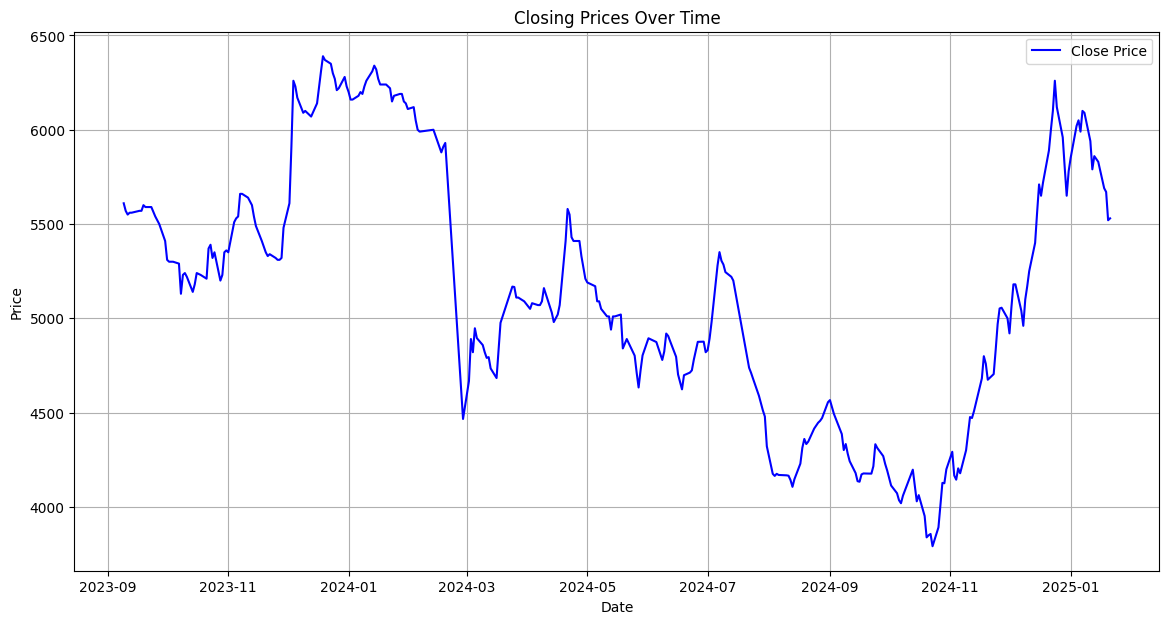

C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['MA10'] = recent_data['CLOSE'].rolling(window=10).mean()
C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['MA20'] = recent_data['CLOSE'].rolling(window=20).mean()
C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

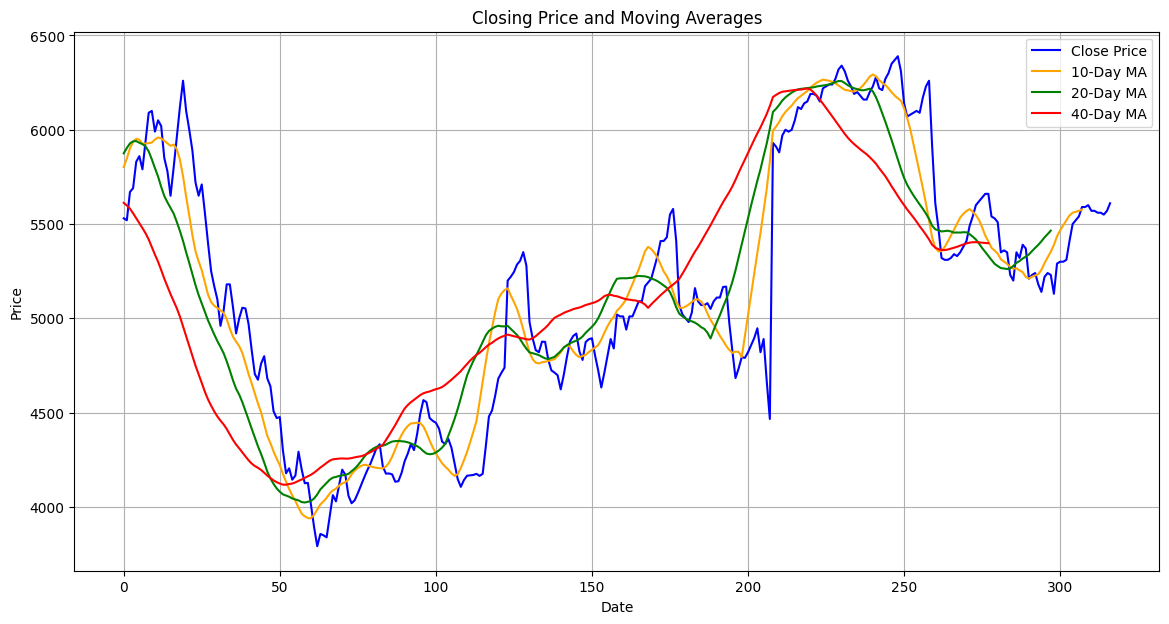

C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['RSI'] = calculate_rsi(recent_data)


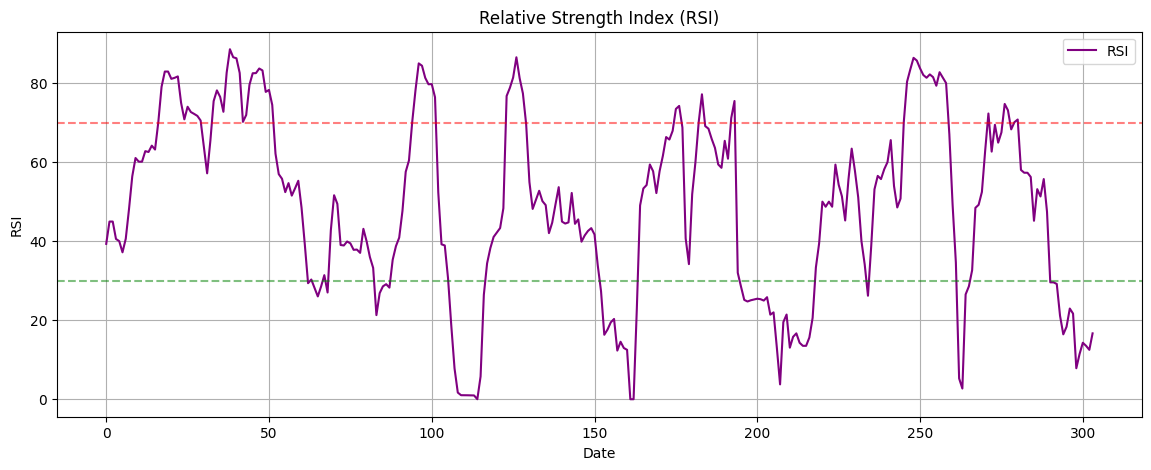

C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['MACD'], recent_data['SIGNAL'] = calculate_macd(recent_data)
C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['MACD'], recent_data['SIGNAL'] = calculate_macd(recent_data)


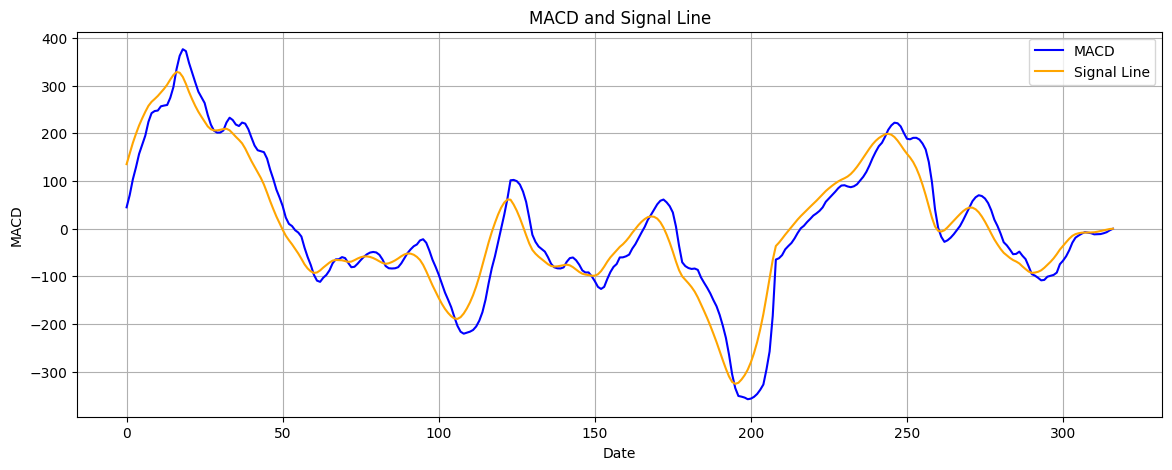

C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TENKAN-SEN'] = (high_9 + low_9) / 2
C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['KIJUN-SEN'] = (high_26 + low_26) / 2
C:\Users\mgs\AppData\Local\Temp\ipykernel_14592\358483827.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

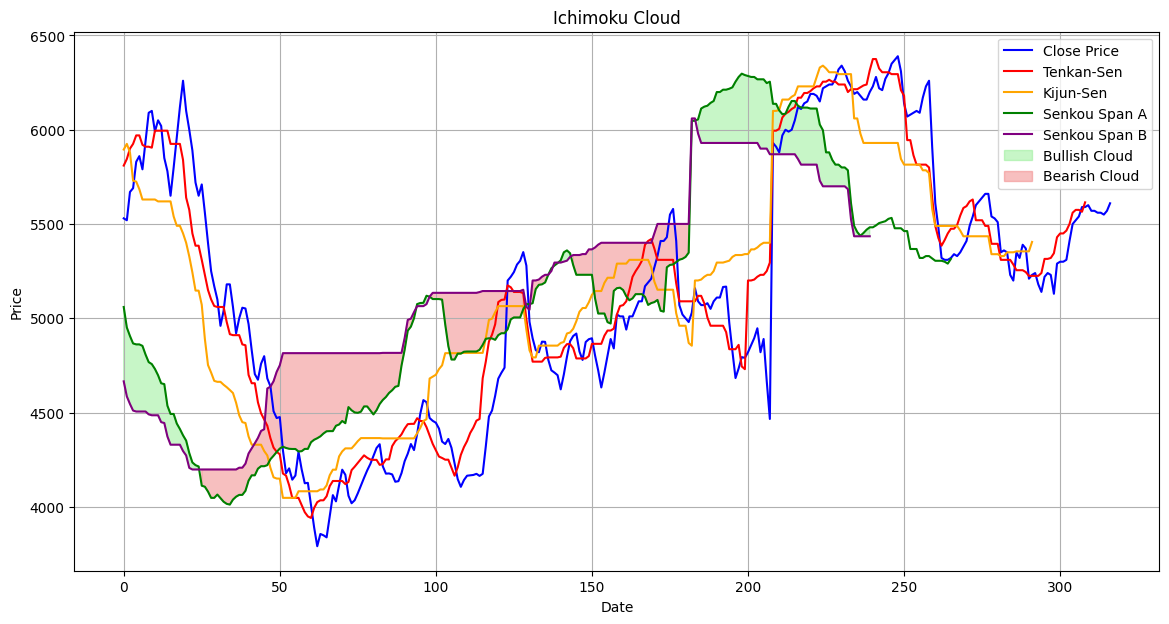

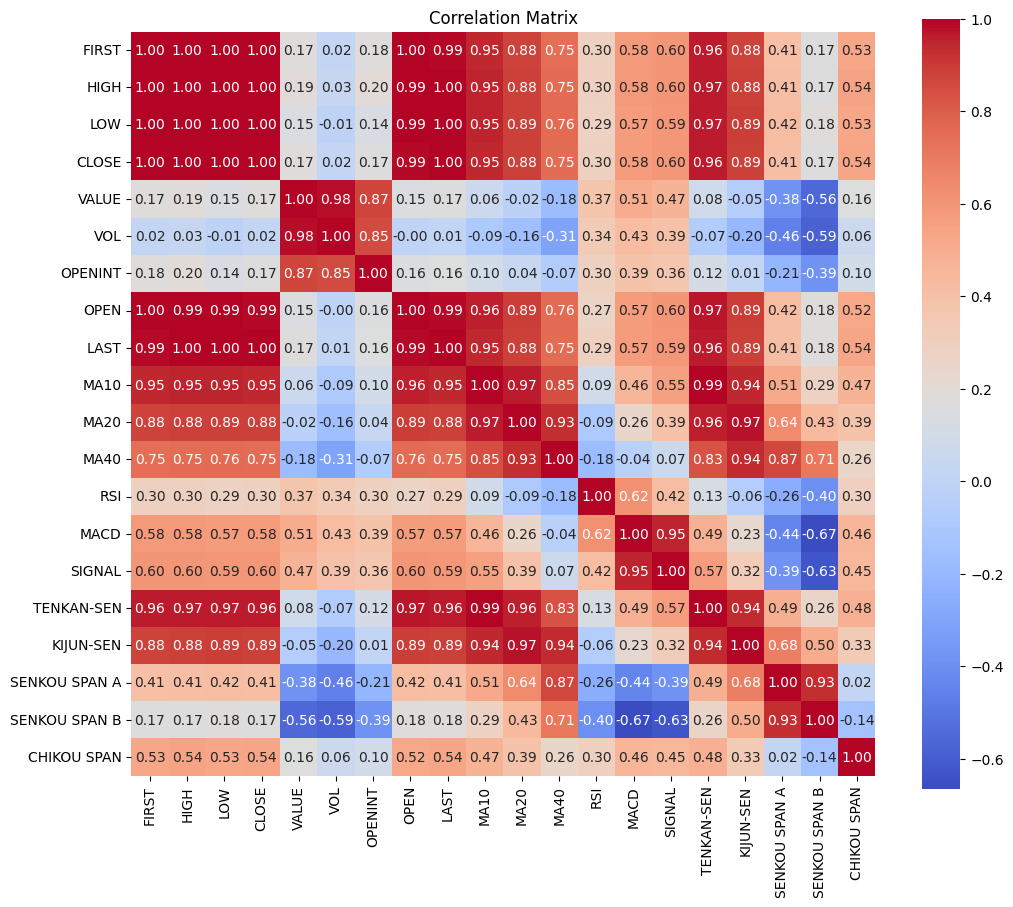

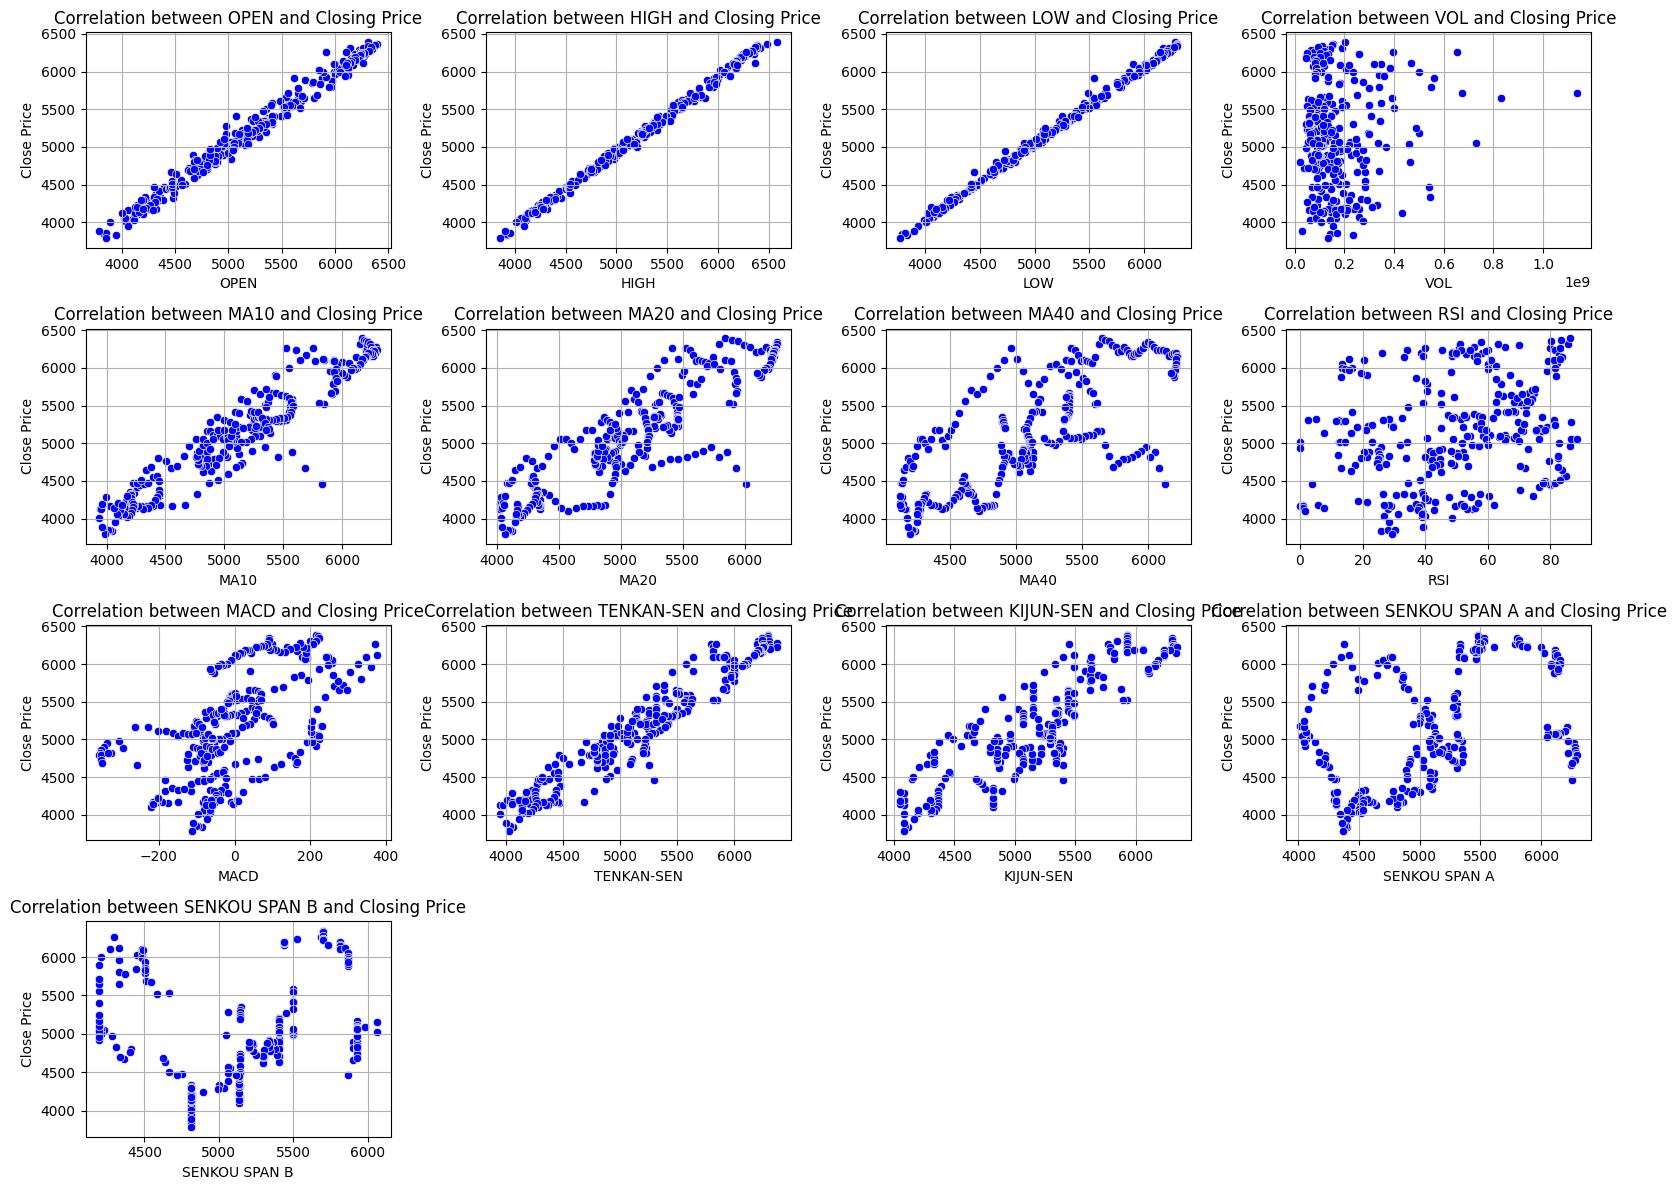

Selected features based on correlation with Closing Price:
['FIRST', 'HIGH', 'LOW', 'OPEN', 'LAST', 'MA10', 'MA20', 'MA40', 'MACD', 'SIGNAL', 'TENKAN-SEN', 'KIJUN-SEN', 'CHIKOU SPAN']
               Model            MSE         MAE        R²         CV MSE  \
0  Linear Regression     188.838157   10.626072  0.999578     275.810308   
1      Decision Tree    1253.953125   25.078125  0.997199    1540.136000   
2                SVM  120986.073123  260.526807  0.729723  168210.180539   
3      Random Forest     620.476333   17.762656  0.998614     693.312137   

                                 Best Params  
0                                         {}  
1                        {'max_depth': None}  
2                 {'C': 10, 'gamma': 'auto'}  
3  {'max_depth': 15, 'min_samples_split': 2}  


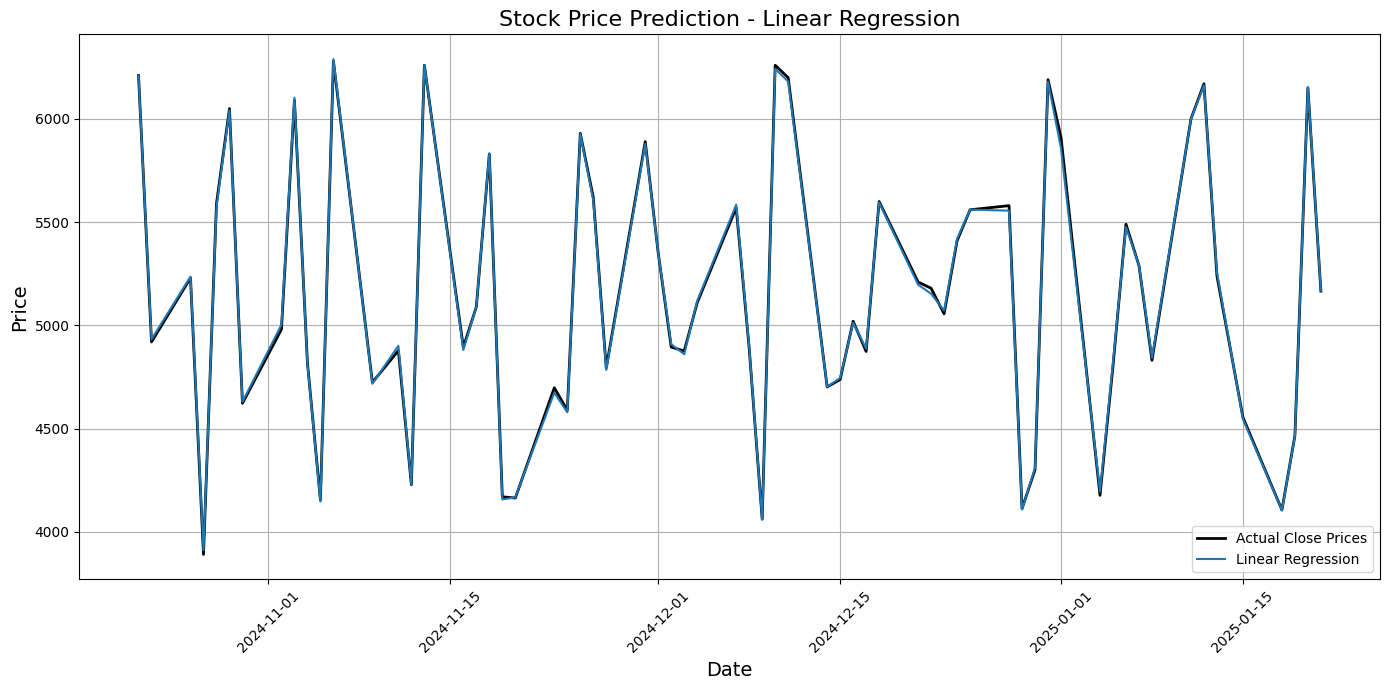

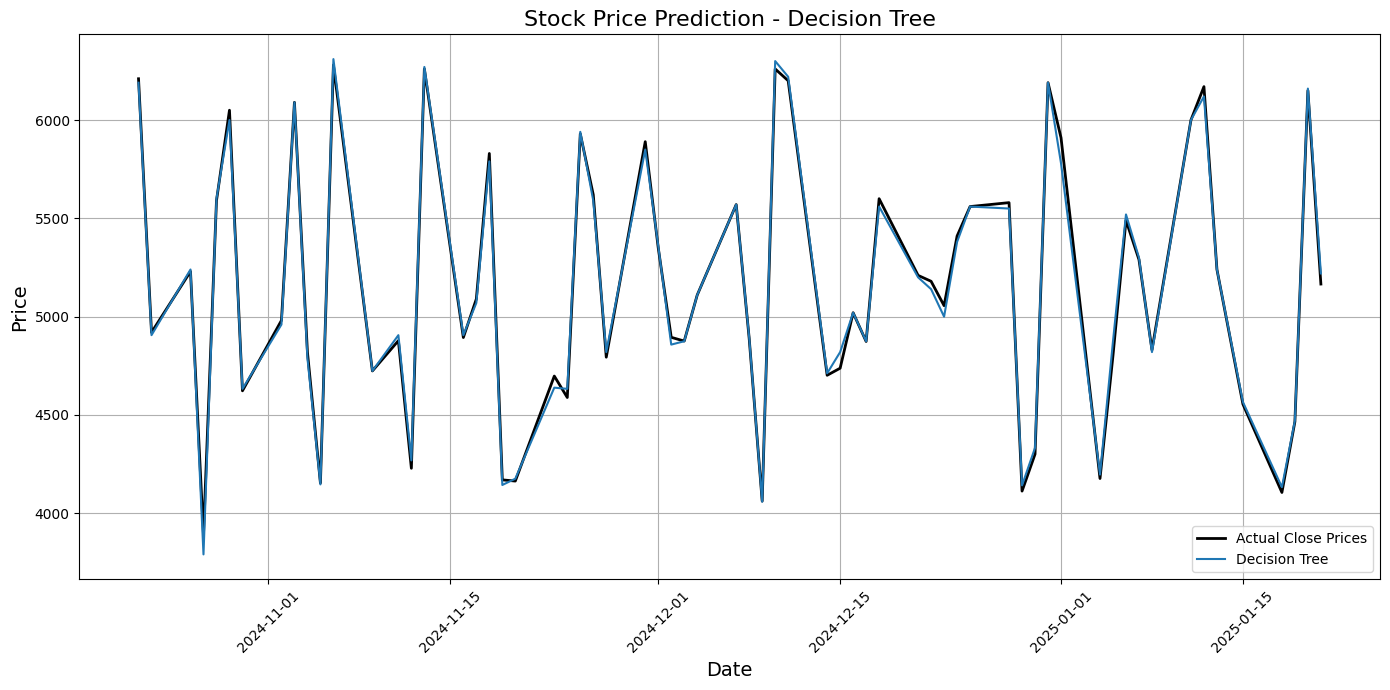

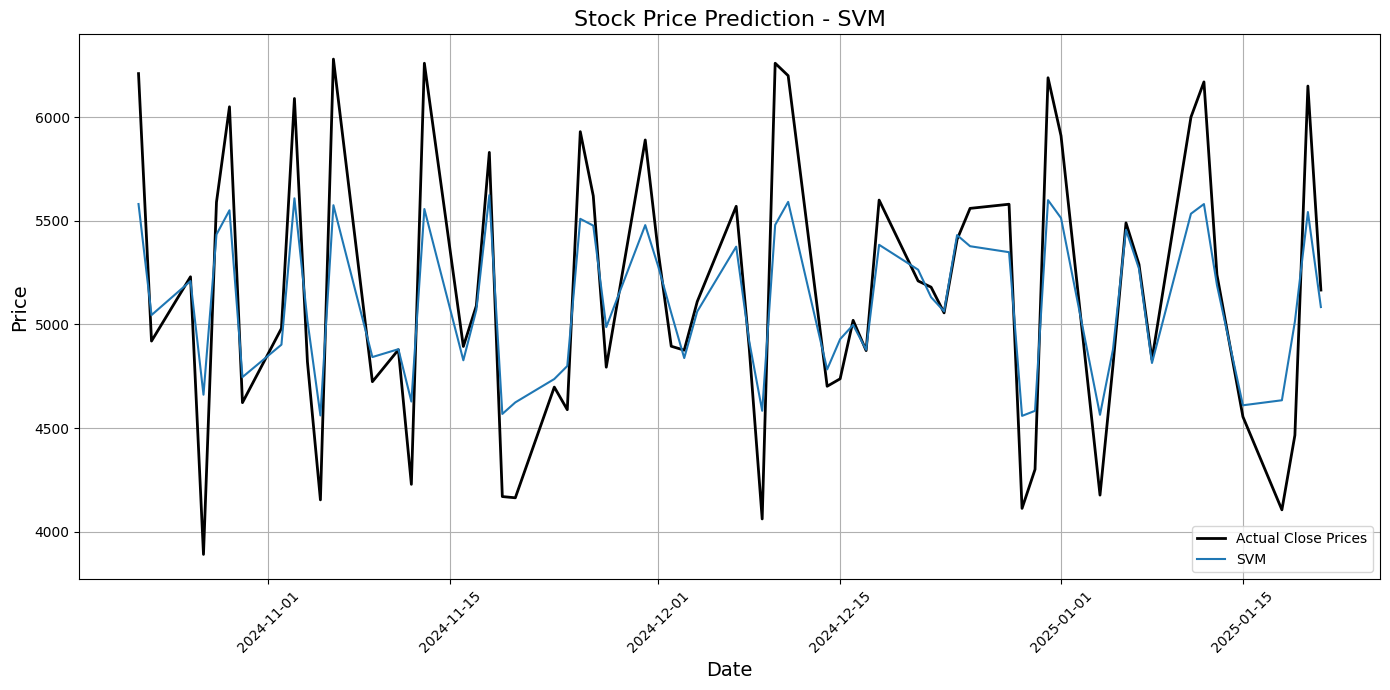

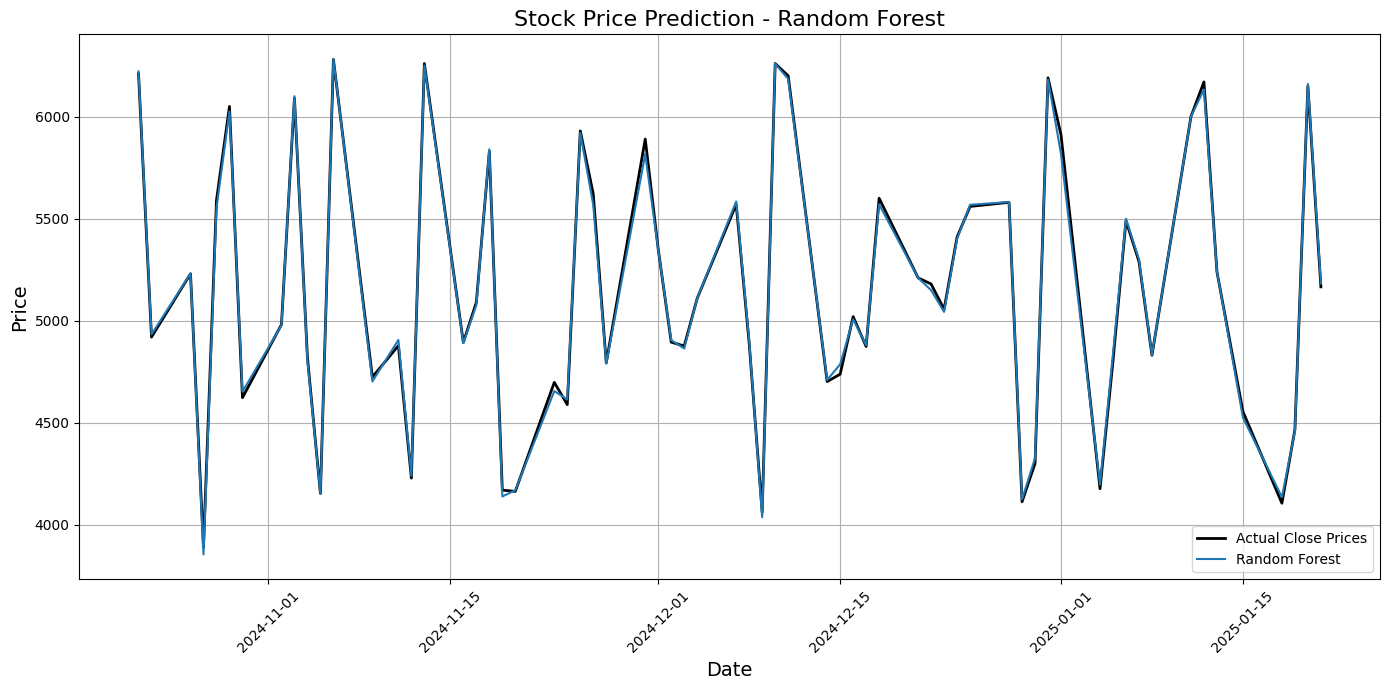

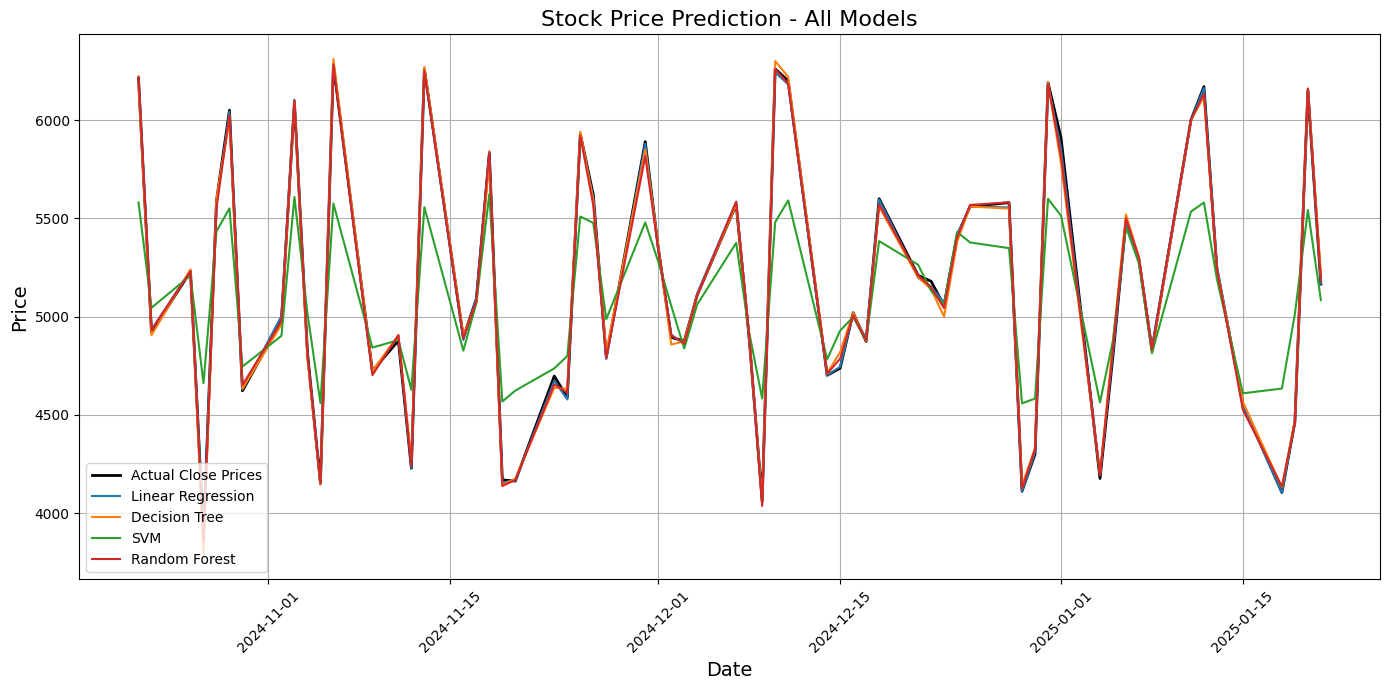

In [14]:
# وارد کردن کتابخانه‌های مورد نیاز
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# بارگذاری داده‌ها از فایل CSV
data = pd.read_csv('S_Mobarakeh.Steel.csv')

# پاک‌سازی نام ستون‌ها
data.columns = data.columns.str.strip().str.upper()

# تبدیل ستون تاریخ به فرمت تاریخ
data['DTYYYYMMDD'] = pd.to_datetime(data['DTYYYYMMDD'], format='%Y%m%d')

# مرتب‌سازی داده‌ها بر اساس تاریخ
data.sort_values('DTYYYYMMDD', inplace=True)

# انتخاب فقط 500 روز اخیر
recent_data = data[data['DTYYYYMMDD'] >= data['DTYYYYMMDD'].max() - pd.Timedelta(days=500)]

# مرحله 1: بررسی ساختار داده‌ها
print("Head of the dataset:\n", recent_data.head())
print("\nInformation about dataset:\n", recent_data.info())
print("\nDescriptive statistics:\n", recent_data.describe())

# مرحله 2: بررسی مقادیر گمشده
print("Missing values before cleaning:\n", recent_data.isnull().sum())
recent_data.dropna(inplace=True)
print("Missing values after cleaning:\n", recent_data.isnull().sum())

# مرحله 4: بررسی روندها و الگوها
plt.figure(figsize=(14, 7))
plt.plot(recent_data['DTYYYYMMDD'], recent_data['CLOSE'], label='Close Price', color='blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# محاسبه میانگین‌های متحرک
recent_data['MA10'] = recent_data['CLOSE'].rolling(window=10).mean()
recent_data['MA20'] = recent_data['CLOSE'].rolling(window=20).mean()
recent_data['MA40'] = recent_data['CLOSE'].rolling(window=40).mean()

# ترسیم قیمت بسته شدن و میانگین‌های متحرک
plt.figure(figsize=(14, 7))
plt.plot(recent_data['CLOSE'], label='Close Price', color='blue')
plt.plot(recent_data['MA10'], label='10-Day MA', color='orange')
plt.plot(recent_data['MA20'], label='20-Day MA', color='green')
plt.plot(recent_data['MA40'], label='40-Day MA', color='red')
plt.title('Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# محاسبه RSI (14 روزه)
def calculate_rsi(data, window=14):
    delta = data['CLOSE'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

recent_data['RSI'] = calculate_rsi(recent_data)

# ترسیم RSI
plt.figure(figsize=(14, 5))
plt.plot(recent_data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

# محاسبه MACD
def calculate_macd(data):
    exp1 = data['CLOSE'].ewm(span=12, adjust=False).mean()
    exp2 = data['CLOSE'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

recent_data['MACD'], recent_data['SIGNAL'] = calculate_macd(recent_data)

# ترسیم MACD
plt.figure(figsize=(14, 5))
plt.plot(recent_data['MACD'], label='MACD', color='blue')
plt.plot(recent_data['SIGNAL'], label='Signal Line', color='orange')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid()
plt.show()

# محاسبه ایچیموکو
def calculate_ichimoku(data):
    high_9 = data['HIGH'].rolling(window=9).max()
    low_9 = data['LOW'].rolling(window=9).min()
    data['TENKAN-SEN'] = (high_9 + low_9) / 2

    high_26 = data['HIGH'].rolling(window=26).max()
    low_26 = data['LOW'].rolling(window=26).min()
    data['KIJUN-SEN'] = (high_26 + low_26) / 2

    data['SENKOU SPAN A'] = ((data['TENKAN-SEN'] + data['KIJUN-SEN']) / 2).shift(26)
    data['SENKOU SPAN B'] = ((data['HIGH'].rolling(window=52).max() + data['LOW'].rolling(window=52).min()) / 2).shift(26)
    data['CHIKOU SPAN'] = data['CLOSE'].shift(-26)

calculate_ichimoku(recent_data)

# ترسیم ایچیموکو
plt.figure(figsize=(14, 7))
plt.plot(recent_data['CLOSE'], label='Close Price', color='blue')
plt.plot(recent_data['TENKAN-SEN'], label='Tenkan-Sen', color='red')
plt.plot(recent_data['KIJUN-SEN'], label='Kijun-Sen', color='orange')
plt.plot(recent_data['SENKOU SPAN A'], label='Senkou Span A', color='green')
plt.plot(recent_data['SENKOU SPAN B'], label='Senkou Span B', color='purple')
plt.fill_between(recent_data.index, recent_data['SENKOU SPAN A'], recent_data['SENKOU SPAN B'], where=(recent_data['SENKOU SPAN A'] >= recent_data['SENKOU SPAN B']), color='lightgreen', alpha=0.5, label='Bullish Cloud')
plt.fill_between(recent_data.index, recent_data['SENKOU SPAN A'], recent_data['SENKOU SPAN B'], where=(recent_data['SENKOU SPAN A'] < recent_data['SENKOU SPAN B']), color='lightcoral', alpha=0.5, label='Bearish Cloud')
plt.title('Ichimoku Cloud')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# محاسبه ماتریس همبستگی
# فقط ستون‌های عددی را انتخاب کنید
numeric_data = recent_data.select_dtypes(include=[np.number])  # انتخاب فقط ستون‌های عددی
correlation_matrix = numeric_data.corr()

# نمایش ماتریس همبستگی به‌صورت تصویری
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

# انتخاب ویژگی‌ها برای تحلیل همبستگی با قیمت بسته شدن
features = ['OPEN', 'HIGH', 'LOW', 'VOL', 'MA10', 'MA20', 'MA40', 'RSI', 'MACD', 'TENKAN-SEN', 'KIJUN-SEN', 'SENKOU SPAN A', 'SENKOU SPAN B']

# ایجاد زیرنمودارها
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()

# تحلیل همبستگی بین هر ویژگی و قیمت بسته شدن
for i, feature in enumerate(features):
    sns.scatterplot(data=recent_data, x=feature, y='CLOSE', color='blue', ax=axes[i])
    axes[i].set_title(f'Correlation between {feature} and Closing Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Close Price')
    axes[i].grid()

# حذف زیرنمودارهایی که استفاده نشده‌اند
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# انتخاب ویژگی‌ها با همبستگی بالای 0.5 یا پایین‌تر از -0.5
threshold = 0.5
strong_correlations = correlation_matrix['CLOSE'][abs(correlation_matrix['CLOSE']) > threshold].index.tolist()
strong_correlations.remove('CLOSE')

print("Selected features based on correlation with Closing Price:")
print(strong_correlations)

# مرحله 6: ویژگی‌ها و هدف
X = recent_data[strong_correlations]
y = recent_data['CLOSE']

# مرحله 7: تقسیم داده‌ها به مجموعه‌های آموزشی و آزمایشی
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# مرحله 8: نرمال‌سازی ویژگی‌ها
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# تعریف مدل‌ها و هایپرپارامترها برای Grid Search
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15]}),
    'SVM': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Random Forest': (RandomForestRegressor(n_estimators=100), {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5]})
}

# ذخیره نتایج
results = {}

# آموزش و ارزیابی هر مدل
for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_cv_score = -grid_search.best_score_
    results[name] = (y_pred, mse, mae, r2, mean_cv_score, grid_search.best_params_)

# جمع‌آوری نتایج
results_list = []
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    results_list.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'CV MSE': mean_cv_score,
        'Best Params': str(best_params)
    })

# ایجاد DataFrame از لیست نتایج
results_df = pd.DataFrame(results_list)
print(results_df)
results_df.to_csv('stock_price_prediction_results.csv', index=False)

# ترسیم نتایج برای هر مدل به‌صورت جداگانه
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(recent_data['DTYYYYMMDD'][-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)
    plt.plot(recent_data['DTYYYYMMDD'][-len(y_test):], y_pred, label=name, linewidth=1.5)
    plt.title(f'Stock Price Prediction - {name}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ترسیم نمودار کلی برای همه مدل‌ها
plt.figure(figsize=(14, 7))
plt.plot(recent_data['DTYYYYMMDD'][-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)
for name, (y_pred, _, _, _, _, _) in results.items():
    plt.plot(recent_data['DTYYYYMMDD'][-len(y_test):], y_pred, label=name, linewidth=1.5)
plt.title('Stock Price Prediction - All Models', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()